## SUMMARY
我们基于Sharpe（1992）建立的模型，选取A股市场中具有代表性的各类风格指数，将所选的标的基金收益予以分解，得到该只基金的风格画像；观察其在一段时间窗口内投资风格漂移程度和获取超越风格资产收益的能力。
在使用该模型前，我们首先对该模型的使用进行校准，以力图降低模型设定误差。
## 1  基金投资风格分析原理
Sharpe（1992）根据资产的多因子模型（Asset Class Factor Models）的原理，提出了以12种大类资产为基础的基金收益率分解方法。首先将资产风格划分为大盘成长、大盘价值、中小盘股、不同期限债券、海外债券和海外股票市场等，然后通过有约束的多元回归方法，以最小化残差平方和为目标，将基金收益率在上述大类资产上予以分解，得到基金在各类风格资产上的近似分布比例。  
模型可表示为：$R_i = \alpha +\beta_1 R_1+\beta_2 R_2 + \epsilon $

## 2 GENERAL SETTINGS  
我们导入本次研究所需的库，对本次研究中要用到的通用函数进行定义。  

In [97]:
# import modules
import numpy as np
import pandas as pd
import scipy.optimize as sco
from WindPy import w
import time
%matplotlib inline
if w.isconnected()!=1:
    w.start()

In [98]:
# functions
def my_winddata_load(fundCode,indexCodelist,myendDate,datafreq):
    # load data from wind database
    # fund existed more than 2 years
    fields  = "Period="+datafreq+";Fill=Previous"
    if datafreq == 'W':
        datalen = 'ED-1Y'
    else:
        datalen = 'ED-2Y'
    wsddata0 = w.wsd(fundCode,'NAV_adj',datalen,myendDate,fields)
    wsddata1 = w.wsd(indexCodelist,'close',datalen,myendDate,fields)
    fundnav  = pd.DataFrame(wsddata0.Data,index=wsddata0.Codes,columns=wsddata0.Times).T
    indexclose = pd.DataFrame(wsddata1.Data,index=wsddata1.Codes,columns=wsddata1.Times).T
    rF = pd.DataFrame(np.log(fundnav/fundnav.shift(1))).dropna()
    rI = pd.DataFrame(np.log(indexclose/indexclose.shift(1))).dropna()
    rI['c0'] = np.zeros_like(rI.iloc[:,1])
    return rF,rI
def my_fund_style_analysis(fundCode,datafreq="W"):
    # para set
    indexCodelist = ['000920.CSI','000921.CSI','H30353.CSI','H30354.CSI','000852.SH','037B.CS','037D.CS','037F.CS']
    indexNamelist = ['LargeCap_Growth','LargeCap_Value','MidCap_Growth','MidCap_Value','SmllCap','ShortBond','MidBond','LongBond','Others']
    n = len(indexCodelist)+1 # n: number of style indexes, adding alpha series
    b0 = np.ones((n,1))/n
    cons = ({'type':'eq','fun':lambda b:sum(b)-1})
    bnds = tuple((0,1) for x in range(n))
    myendDate = time.strftime('%Y-%m-%d',time.localtime(time.time()))
    resStylecom = pd.DataFrame()
    # data window
    if datafreq == 'W':
        funDataWindow = 12 # 6 months
    elif datafreq == 'M':
        fundDataWindow = 12    
    # sub functions
    def my_cal_negRa(b):
        # b: the coefficient vector of     
        # N: number of observations
        yhat = pd.DataFrame(np.dot(x,b),index=y.index,columns=y.columns)
        RSS = ((yhat-y)**2).sum()
        TSS = (N-1) * (y.std()**2)
        Ra2 = 1 - RSS/TSS * (N-1)/(N-n-1)
        return -Ra2
    # load data
    rF,rI= my_winddata_load(fundCode,indexCodelist,myendDate,datafreq)
    N = len(rF)
    # cal style
    for t in range(funDataWindow,len(rF)):
        # variables name should be same with thoose in min_cal func
        y = rF[t-funDataWindow:t] # y : ret of fund i
        x = rI[t-funDataWindow:t] # x : ret of index matrix
        m = sco.minimize(my_cal_negRa,b0,method='SLSQP',bounds=bnds,constraints=cons)
        resFi = pd.DataFrame(m.x,index=[x.columns],columns=[x.index[-1:]]).T
        resStylecom = pd.concat([resStylecom,resFi],join='outer')
    resStylecom.columns = indexNamelist
    resStylecom.index = resStylecom.index.strftime('%Y-%m-%d')
    resStylecom.plot(kind='bar', stacked=True,figsize=(12,10))
    ## save file
    #saveFilepath = 'E:/fund_analysis_res_'+fundCode[:6]+'_end_at_'+myendDate
    #resStylecom.to_csv(saveFilepath+'.csv') 

## 3 模型校准
### 3.1 ETF校准
我们分别采用沪深300ETF（510300.OF）、中证500ETF（510500.OF）和国债ETF（511010.OF）进行模型的校正。同时，将指数增强ETF纳入模型校准中。

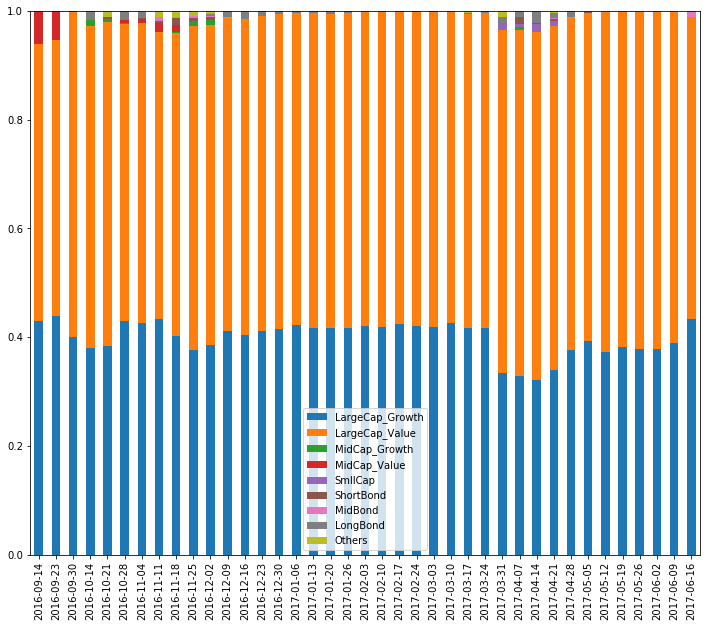

In [99]:
my_fund_style_analysis('510300.OF')

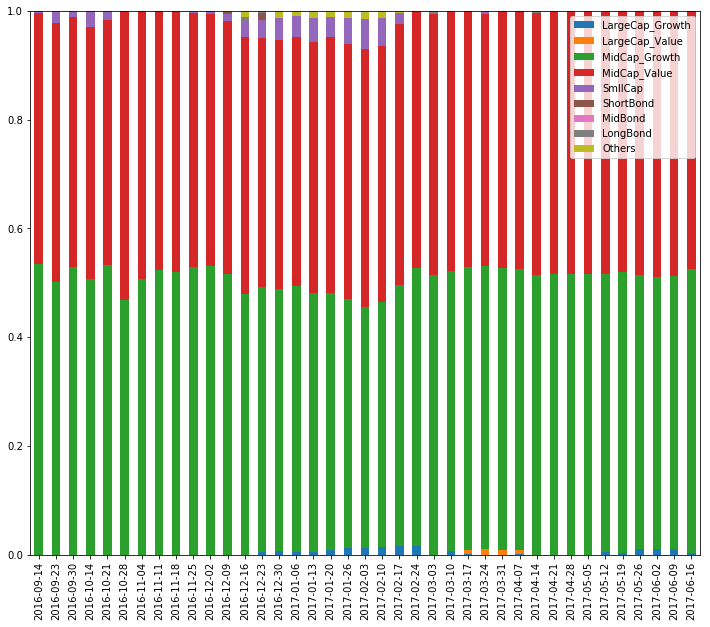

In [100]:
my_fund_style_analysis('510500.OF')

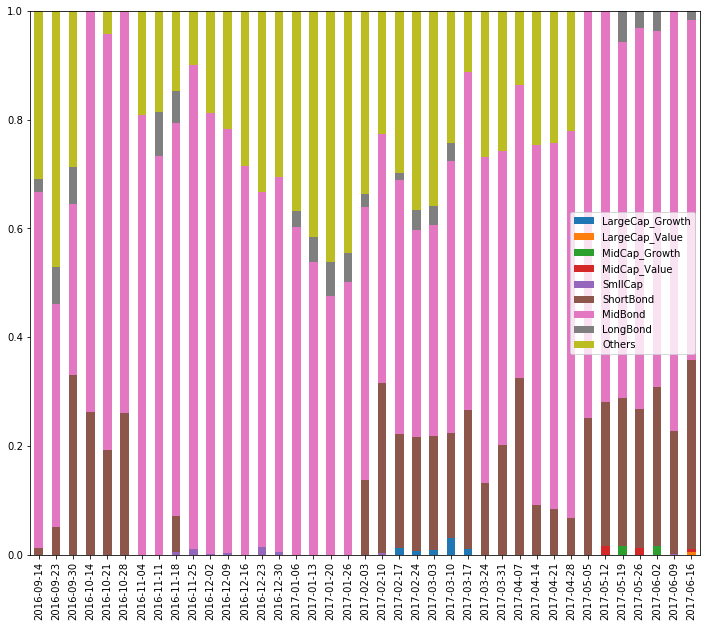

In [101]:
my_fund_style_analysis('511010.OF') # 国债ETF

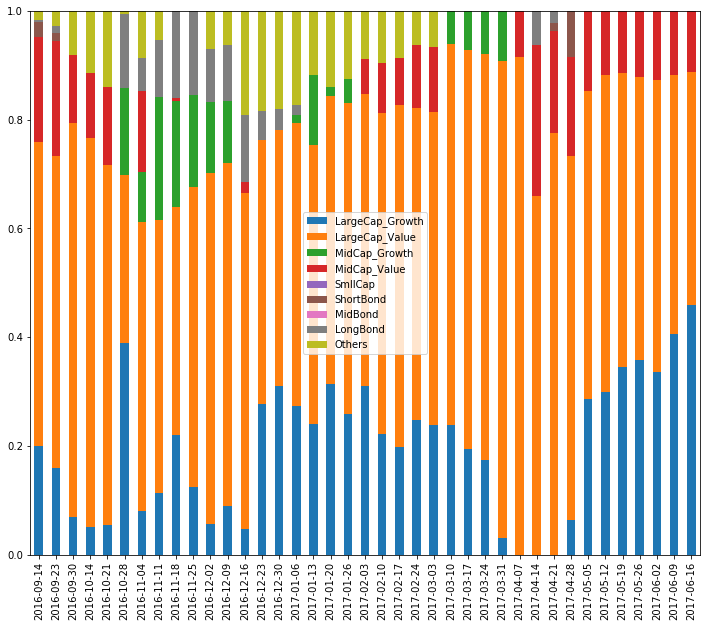

In [102]:
my_fund_style_analysis('000176.OF') # 嘉实沪深300增强

### 3.2 主动管理型基金校准
根据基金季报披露持仓数据进行校准。参与校准的基金有：嘉实研究阿尔法（000082.OF）、创金合信量化多因子（002210.OF）、申万菱信量化小盘（163110.OF）、长信量化中小盘（519975.OF）

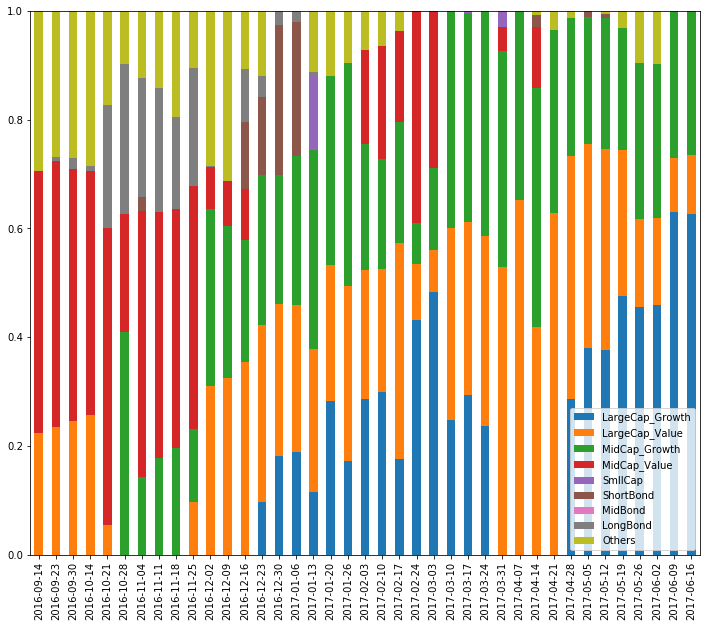

In [103]:
my_fund_style_analysis('000082.OF') # 嘉实研究阿尔法

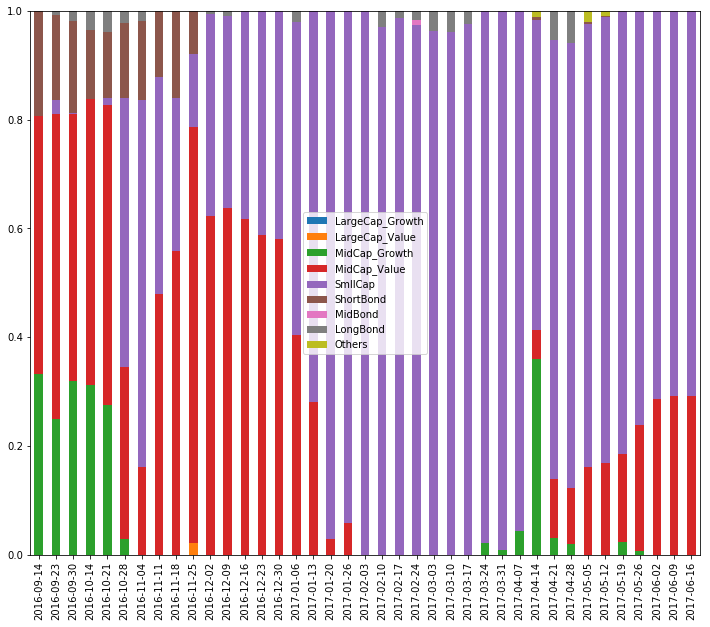

In [104]:
my_fund_style_analysis('002210.OF') #创金合信量化多因子

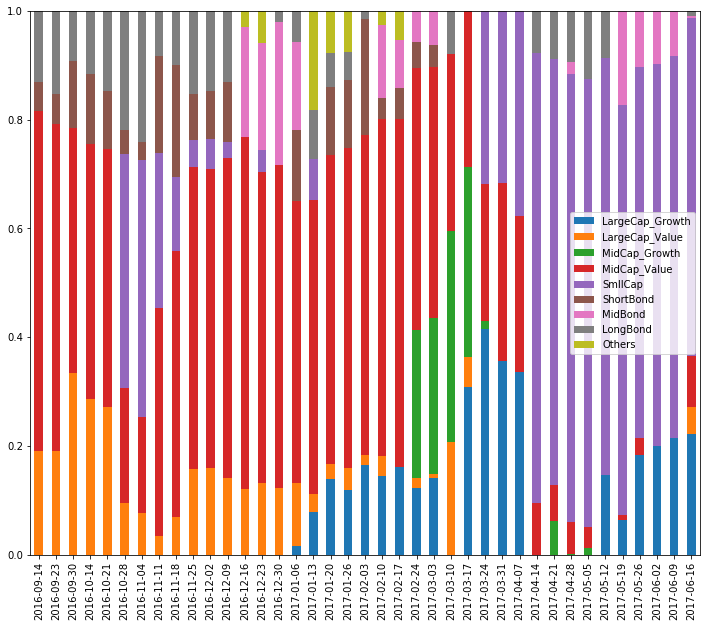

In [105]:
my_fund_style_analysis('163110.OF') # 申万菱信量化小盘

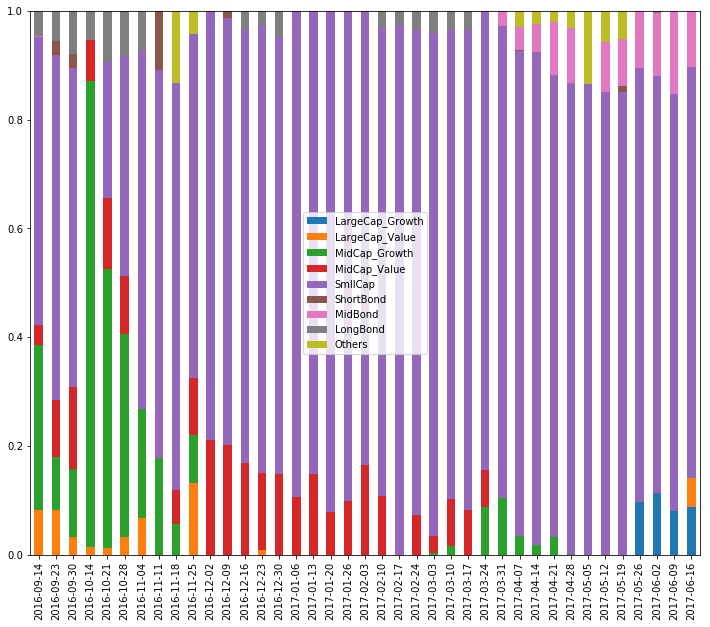

In [106]:
my_fund_style_analysis('519975.OF') #长信量化中小盘

## 4. 模型实证
### 4.1 重点基金

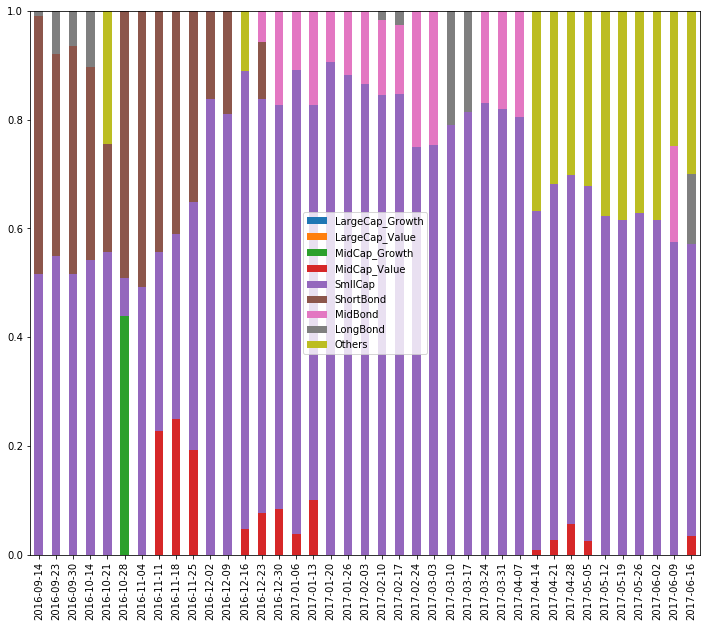

In [107]:
my_fund_style_analysis('J131542.OF') # 大岩量化1期

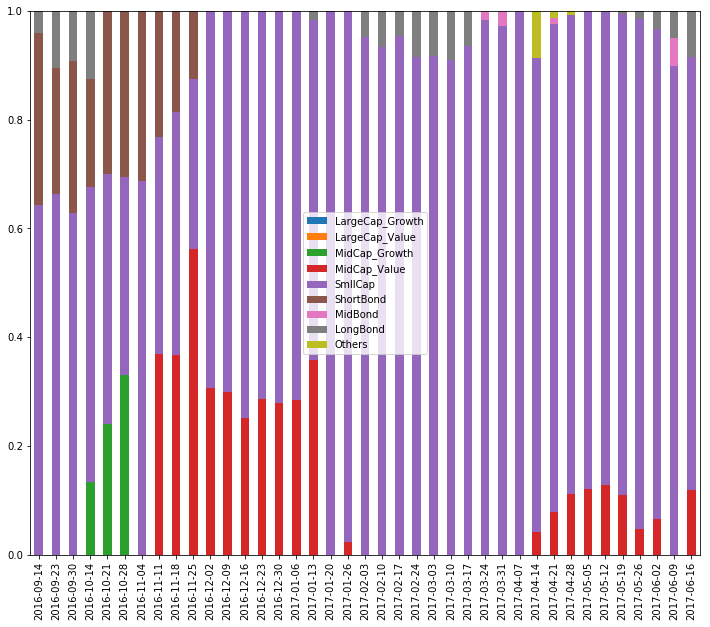

In [108]:
my_fund_style_analysis('J140286.OF') # 大岩量化进取